## Job Reports 2022
### Table of Contents
1. Text cleaning and extraction
1. Wordcloud
1. Sentiment Analysis

In [1]:
import pandas as pd
import os, json
import pandas as pd
import numpy as np
import glob
import re
import sys

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
np.set_printoptions(threshold=sys.maxsize)


In [8]:
companies = {
    '1': 'Safaricom', 
    '2': 'EABL', 
    '3': 'UN, United Nations', 
    '4': 'KRA', 
    '5': 'KenGen', 
    '6': 'KPC, Kenya Pipeline Company', 
    '7': 'Coca cola', 
    '8':'Deloitte', 
    '9': 'Unilever', 
    '10': 'Kplc, Kenya Power', 
    '11': 'Google', 
    '12': 'KPA, Kenya Ports Authority',
    '13': 'KCB, Kenya Commercial Bank', 
    '14': 'Microsoft', 
    '15': 'Bidco', 
    '16': 'RMS, Royal Media Services', 
    '17': 'KEMRI, Kenya Medical Research Institute',
    '18': 'Amref'
}

Export tweets (json format)

In [2]:

# f = open('./dayta/1-json.json')
arr = []
path_to_json = './dayta/'
json_pattern = os.path.join(path_to_json, '*.json')
file_list = glob.glob(json_pattern)

# print(file_list)

for file in file_list:
    with open(file) as f:
        temp = json.load(f)
        for line in temp['data']:
            arr.append(line)



df = pd.DataFrame(data=arr)
# save to csv
df.to_csv('./out/collated.csv')

df = df[['text', 'created_at']]

# df.head(100)

#### Text Cleaning and Extraction

##### Pre-processing

In [3]:
txt_lower = df['text'].str.lower()
txt_l_cln = txt_lower.str.replace("\@wanjikureports", "") #replace wanjiku mentions
txt_l_cln2 = txt_l_cln.str.replace("(\n*\d\.)", '') #replace ordered listings e.g. 1., 2. etc
narr = txt_l_cln2.to_numpy()

**Pseudocode**

Each listitem in list
- Remove all stop words
- Split all words/numbers
- Check whether word in company list, if in list add to output var -> use eigenvalues, check for closeness of word
- check each # with company list key, add value to output list

In [4]:
from stop_words import get_stop_words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = list(get_stop_words('en'))  # About 900 stopwords
nltk_words = list(stopwords.words('english'))  # About 150 stopwords
stop_words.extend(nltk_words)

In [5]:
from difflib import SequenceMatcher
import jellyfish

def similar(a, b):
    return jellyfish.jaro_distance(a, b)  # prob threshhold set at 0.75
    # return SequenceMatcher(None, a, b).ratio()


def returnFromNumeric(numstr):
    if 1 <= int(numstr) <= 18:
        splt = companies[numstr].split(',')
        return splt[0]

# https://stackoverflow.com/questions/51217909/removing-all-emojis-from-text


def replaceEmoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U0001F1F2-\U0001F1F4"  # Macau flag
                               u"\U0001F1E6-\U0001F1FF"  # flags
                               u"\U0001F600-\U0001F64F"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U0001F1F2"
                               u"\U0001F1F4"
                               u"\U0001F620"
                               u"\u200d"
                               u"\u2640-\u2642"
                               "]+", flags=re.UNICODE)

    return emoji_pattern.sub(r'', text)


def returnFromStr(thestr):
    output = None

    for val in companies.values():
        splt = val.split(',')

        selected = splt[0]
        prob = similar(thestr, splt[0].strip().lower())
        prob2 = 0
        
        if len(splt) > 1:
            prob2 = similar(thestr, splt[1].strip().lower())
            
        prob = prob2 if prob2 > prob else prob
        
#         apparently, as per test below kenya_ports is closer to kplc than kpa!
#         print(similar('kenya_ports', 'Kenya Ports authority'.lower()))
#         print(similar('kenya_ports', 'Kenya power'.lower()))
#         Capture manually
        if selected.lower() == 'kplc' and 'port' in thestr:
            prob = 0

        if prob >= .75:
            if output is not None:
                prev_prob = similar(thestr, output.lower())
                if prob > prev_prob:
                    output = selected
            else:
                output = selected
                    
#     if output is not None:
#         print('<b>Tumetoa: {}</b>'.format(output))

    return output

In [6]:
similar('kenya_ports', 'Kenya Ports Authority'.lower())

# thevar = 'KPA, Kenya pipes'.split(',')
# print(thevar[0])
# if (len(thevar) > 1):
#     print(thevar[1])

0.7950937950937952

**Correct for numbers errors, when numbers are separated by a comma!**

In [9]:
output_arr = []
test = narr[:5]

for i, sentence in enumerate(narr):
    internal_arr = []
    if i not in [1096]: #908, 1073, 1096
        final_tokens = []
#         tokens = [word for word in word_tokenize(sentence) if word.lower() == 'un' and not word in stopwords.words()] 
        tokens = word_tokenize(sentence)
        for tkn in tokens:
            if tkn.lower() == 'un':
                final_tokens.append(tkn)
            else:
                if tkn not in stopwords.words():
                    final_tokens.append(tkn)
            
            
#         print('\n----------------------------\n{} {} {}\n---------------------------'.format(i, sentence, tokens))
        
        for token in final_tokens:
            if token.isnumeric():
                internal_arr.append(returnFromNumeric(token))
            else:
                ret_str = returnFromStr(token)
#                 print(ret_str)
                internal_arr.append(ret_str)
        
        print(i, sentence, final_tokens, internal_arr, '\n')
                
    
    output_arr.append(list(set(internal_arr)))
    
    
#flatten output_arr
output_arr = [element for sublist in output_arr for element in sublist]
    

0  @kenya_ports of course. i've been dying to get even just an internship here. ['@', 'kenya_ports', 'course', '.', "'ve", 'dying', 'get', 'even', 'internship', '.'] [None, 'KPA', None, None, None, None, None, None, None, None] 

1  6 ['6'] ['KPC'] 

2  7 ['7'] ['Coca cola'] 

3  amref ['amref'] ['Amref'] 

4  where are the hustler companies? ['hustler', 'companies', '?'] [None, None, None] 

5  8,11 or 1🙏amen. ['8,11', '1🙏amen', '.'] [None, None, None] 

6  kpa ['kpa'] ['KPA'] 

7  not a sucker for employment, but i won't mind working at; google microsoft deloitte unilever ['sucker', 'employment', ',', "n't", 'mind', 'working', ';', 'google', 'microsoft', 'deloitte', 'unilever'] [None, None, None, None, None, None, None, 'Google', 'Microsoft', 'Deloitte', 'Unilever'] 

8  mimi nipewe kazi kwa serekali hapo ndio ntaiba vizuri ['mimi', 'nipewe', 'kazi', 'kwa', 'serekali', 'hapo', 'ndio', 'ntaiba', 'vizuri'] [None, None, None, 'KRA', None, None, None, None, None] 

9  my own [] [] 

10  

In [10]:
# tt= narr[908]
# nt = replaceEmoji(tt)
# print(nt)

# word_tokenize(nt)
# # narr[908]

# output_arr

In [16]:
finalarr = [txt for txt in output_arr if txt is not None]

# finalarr

In [17]:
corpus = "; ".join(finalarr)
# corpus

In [18]:
cols = ['Companies']
df_out = pd.DataFrame(finalarr, columns = cols )
df_grp = df_out.groupby(cols).size().reset_index(name='Count')

In [19]:
df_grp.sort_values(by='Count', ascending=False)

,Companies,Count
16,UN,263
5,Google,164
15,Safaricom,145
11,KenGen,144
4,EABL,122
0,Amref,119
10,KRA,115
12,Kplc,96
13,Microsoft,93
3,Deloitte,63


In [29]:
# word_could_dict=Counter(finalarr)

# word_could_dict

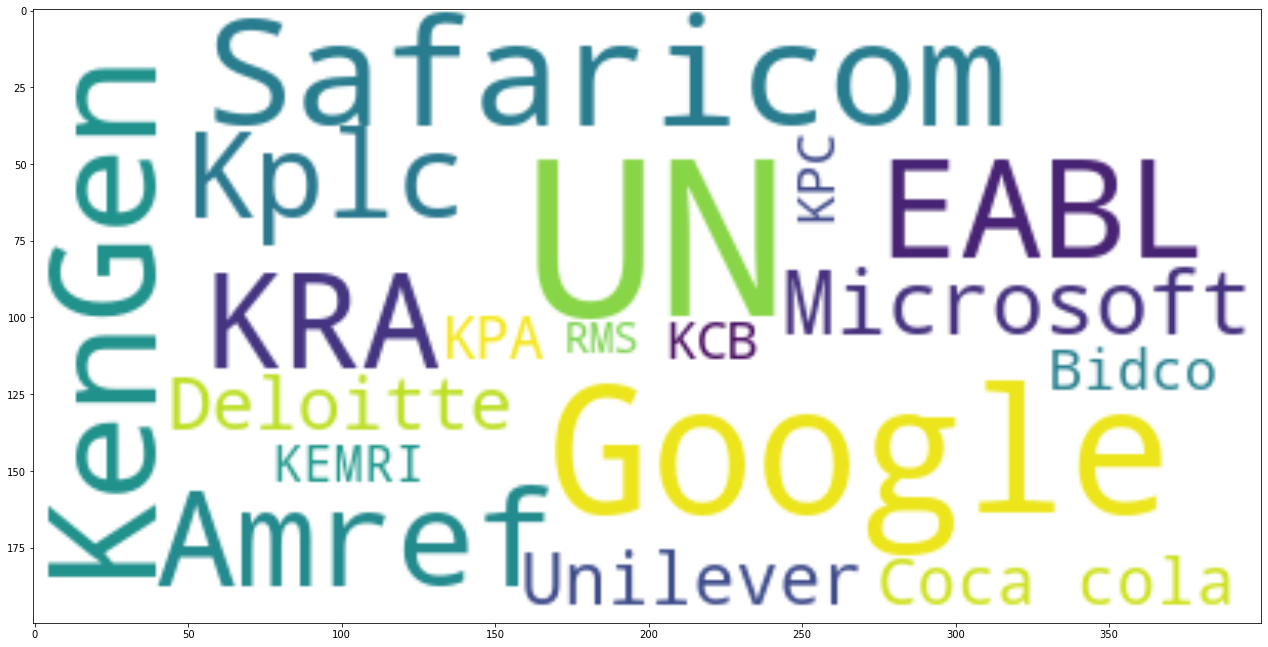

In [35]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
import matplotlib.pyplot as plt

word_could_dict=Counter(finalarr)

wordcloud = WordCloud(background_color="white").generate_from_frequencies(word_could_dict) #.generate(corpus) #.generate_from_frequencies(word_could_dict)    
#Post processing
#ii. plot word cloud model
plt.figure(figsize = (22,22))
plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")
plt.savefig('jdi-3-2023.png')
plt.show()

#### Notes
Its important to note changes to metrics the last 3 days - Amref moved from 2nd to 3rd etc

**Note** these interpretations are time-bound and decay over time hence it's important to keep updating this data


Save to csv

In [15]:
df_grp.sort_values(by='Count', ascending=False).to_csv('./out/sortedout.csv')